# Get relevant libraries

In [299]:
import ujson as json
import pprint
import pandas as pd
import numpy as np
import datetime
import time
import datetime
import calendar
import seaborn as sns

import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from ggplot import *

# All plots should be inside notebook

In [300]:
%matplotlib inline
pd.options.mode.chained_assignment = None  # remove default='warn'

# Import data

In [301]:
filename = "/Users/fnokeke/dev/student-streams/dataset/LocationHistory.json"
with open(filename) as json_file:
    raw = json.load(json_file)

ld = pd.DataFrame(raw['locations'])
print("Number of items in data: %d") % len(ld)

# free up memory
del raw

Number of items in data: 266972


# Convert to typical units and rename columns

In [303]:
ld['latitudeE7'] = ld['latitudeE7']/float(1e7)
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000)
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)
ld['date'] = ld.datetime.map(lambda x: x.strftime("%Y-%m-%d")) # TODO: remove

ld.rename(columns={
'latitudeE7': 'latitude',
'longitudeE7': 'longitude',
'timestampMs': 'timestamp'
}, inplace=True)

# Glimpse of raw data

In [336]:
print ld.dtypes
ld.head()

accuracy              int64
activitys            object
altitude            float64
heading             float64
latitude            float64
longitude           float64
timestamp           float64
velocity            float64
datetime     datetime64[ns]
date                 object
dtype: object


,accuracy,activitys,altitude,heading,latitude,longitude,timestamp,velocity,datetime,date
0,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445009,-76.481233,1.444430e+09,NaN,2015-10-09 18:40:49.815,2015-10-09
1,20,NaN,NaN,NaN,42.445002,-76.481257,1.444430e+09,NaN,2015-10-09 18:39:49.791,2015-10-09
2,53,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445001,-76.481254,1.444430e+09,NaN,2015-10-09 18:38:48.981,2015-10-09
3,51,"[{u'activities': [{u'confidence': 85, u'type':...",NaN,NaN,42.444977,-76.481236,1.444430e+09,NaN,2015-10-09 18:37:48.476,2015-10-09
4,37,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444994,-76.481249,1.444430e+09,NaN,2015-10-09 18:36:59.451,2015-10-09


# Get only a specific number of weeks of data from specific start date

In [337]:
no_of_weeks = 1
no_of_days = no_of_weeks * 7

# Get date in string format

In [338]:
start_date = ld[ld.date=='2014-11-09'].date.head(1)
start_date = pd.to_datetime(start_date)

dates = []
for i in range(no_of_days):
    x = (start_date + datetime.timedelta(days=-i)).to_string()[9:] # horrible tweak to get date in string format
    dates.append(x)
    
ld_wk = ld[ld.date.isin(dates)]
print "Week length:", len(ld_wk)
print dates[:5]

Week length: 7791
[u'2014-11-09', u'2014-11-08', u'2014-11-07', u'2014-11-06', u'2014-11-05']


# Ignore locations with accuracy estimates over 1000m

In [339]:
ld_wk = ld_wk[ld_wk.accuracy < 1000]
ld_wk.reset_index(drop=True, inplace=True)
print("Number of items in data: %d") % len(ld_wk)

Number of items in data: 7770


# Select only columns of interest

In [340]:
ld_wk = ld_wk[['latitude', 'longitude', 'datetime', 'date']]

# Specify places of interest in Ithaca and ignore locations outside Ithaca

In [341]:
home = (42.446594, -76.493736)
work = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0

ld_wk = ld_wk[abs(ld_wk.latitude - home[0]) < lat_margin]
ld_wk = ld_wk[abs(ld_wk.longitude - home[1]) < lon_margin]
print("Number of items in data: %d") % len(ld_wk)
ld_wk.head()
print "No of unique dates:", len(set(ld_wk.date))

Number of items in data: 7770
No of unique dates: 7


# Label every location as either home, work or other

In [342]:
lat_error_margin = 0.0005
lon_error_margin = 0.005

POINTS = {
    'home': home,
    'work': work
}

def get_loc_label(df, points):
    for label, point in points.items():
        within_lat = abs(df['latitude'] - point[0]) <= lat_error_margin
        within_lon = abs(df['longitude'] - point[1]) <= lon_error_margin
        if (within_lat and within_lon):
            return label
    else:
        return 'other'

ld_wk['loc_label'] = ld_wk.apply(lambda x: get_loc_label(x, POINTS), axis='columns')

# Show sample locations of home, work, other

In [343]:
rows = [0,1,59,60,61,62]
ld_wk[ld_wk['date'] == ld_wk.date[0]].iloc[rows]

,latitude,longitude,datetime,date,loc_label
0,42.449137,-76.477510,2014-11-09 23:59:18.731,2014-11-09,other
1,42.449135,-76.477484,2014-11-09 23:58:30.267,2014-11-09,other
59,42.448757,-76.477052,2014-11-09 22:42:36.146,2014-11-09,other
60,42.448759,-76.477058,2014-11-09 22:41:45.952,2014-11-09,other
61,42.448787,-76.476725,2014-11-09 22:37:19.310,2014-11-09,other
62,42.448752,-76.477033,2014-11-09 22:32:18.515,2014-11-09,other


# Resample location patterns data by different time period

In [344]:
loc_patterns = ld_wk[['datetime', 'loc_label']]
loc_patterns = loc_patterns.set_index('datetime')
loc_patterns['freq'] = 0
loc_group = loc_patterns.groupby(['loc_label']).resample('6H',how=len)
loc_group = loc_group.reset_index()
loc_group.head()

,loc_label,datetime,freq
0,home,2014-11-03 00:00:00,174
1,home,2014-11-03 06:00:00,111
2,home,2014-11-03 12:00:00,0
3,home,2014-11-03 18:00:00,108
4,home,2014-11-04 00:00:00,177


In [345]:
loc_group = loc_group.groupby(['datetime','loc_label']).sum()
loc_group.head()

freq
datetime            loc_label      
2014-11-03 00:00:00 home        174
2014-11-03 06:00:00 home        111
                    other         6
                    work        139
2014-11-03 12:00:00 home          0

In [346]:
loc_group.unstack().head()

freq           
loc_label           home other work
datetime                           
2014-11-03 00:00:00  174   NaN  NaN
2014-11-03 06:00:00  111     6  139
2014-11-03 12:00:00    0    86  248
2014-11-03 18:00:00  108     5  196
2014-11-04 00:00:00  177     1    0

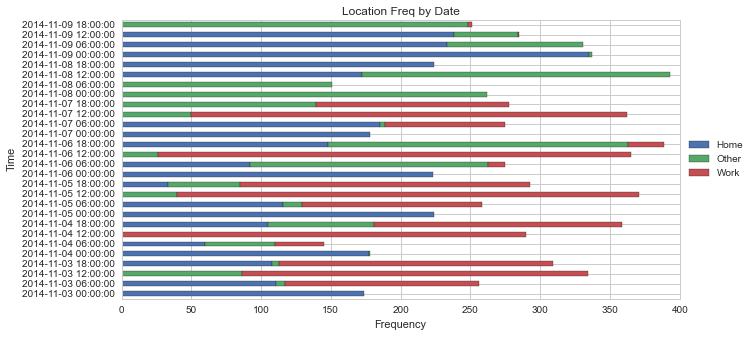

In [754]:
loc_plot = loc_group.unstack().plot(kind='barh', stacked=True, title="Location Freq by Date", figsize=(10,5))
loc_plot.set_xlabel("Frequency")
loc_plot.set_ylabel("Time")
r = loc_plot.legend(["Home","Other","Work"],loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

# Mark every day by the day name

In [674]:
weekday_patterns = ld_wk[['datetime', 'loc_label']]
weekday_patterns['weekday'] = weekday_patterns.datetime.map(lambda x: calendar.day_name[x.weekday()])
weekday_patterns['day'] = weekday_patterns.datetime.map(lambda x: x.weekday())
weekday_patterns.head()

,datetime,loc_label,weekday,day
0,2014-11-09 23:59:18.731,other,Sunday,6
1,2014-11-09 23:58:30.267,other,Sunday,6
2,2014-11-09 23:57:37.062,other,Sunday,6
3,2014-11-09 23:56:46.554,other,Sunday,6
4,2014-11-09 23:55:56.987,other,Sunday,6


# ggplot of day_of_week vs location frequency (stacked bar)

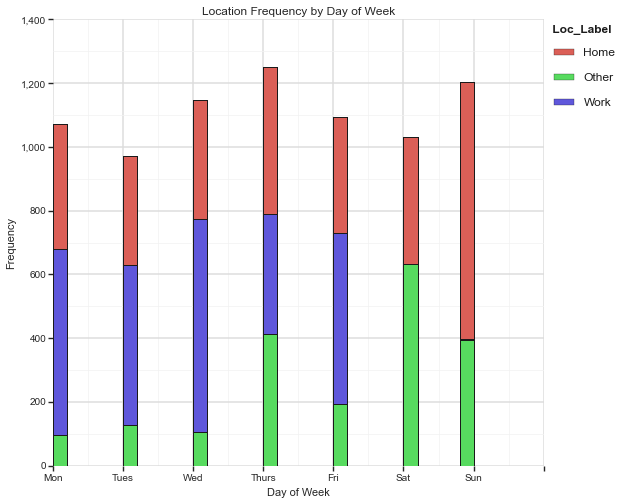

<ggplot: (475504985)>

In [556]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")

ggplot(weekday_patterns, aes("day", fill='loc_label')) + geom_bar() + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_seaborn()

# ggplot of day_of_week vs location frequency (multiple lines)

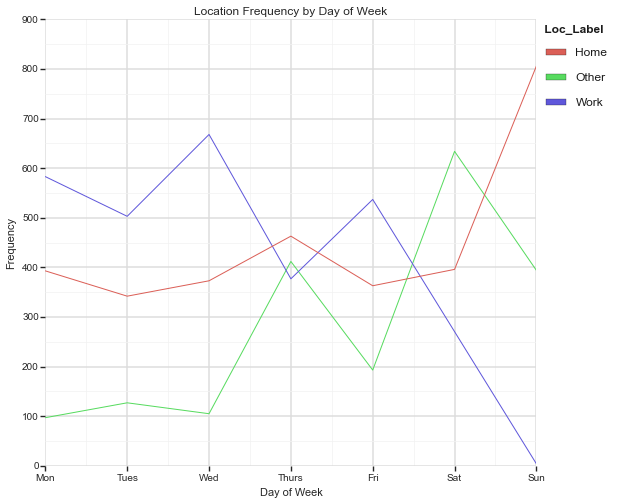

<ggplot: (478288937)>

In [612]:
wkdf = weekday_patterns[['day', 'loc_label']]
wkdf['freq'] = 0
wkdf = wkdf.groupby(['day', 'loc_label']).count().reset_index()

ggplot(wkdf, aes('day', 'freq', color='loc_label')) + geom_line() + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_seaborn()

# Show location frequency by date (ggplot)

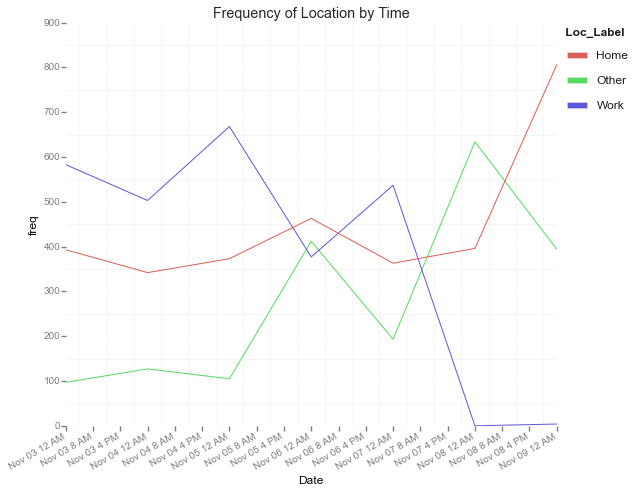

<ggplot: (500202153)>

In [753]:
date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['freq'] = 0

date_df = date_df.set_index('datetime')
date_df = date_df.groupby('loc_label').resample('D', how='count').reset_index()

ggplot(date_df, aes('datetime', 'freq', color='loc_label')) + \
    geom_line() + \
    scale_x_date(name="Date", labels="%b %d %-I %p", breaks=date_breaks("8 hours")) + \
    ggtitle("Frequency of Location by Time") + \
    theme_bw()

# Datetime by barchart (ggplot)

In [728]:
date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['freq'] = 0

pp = date_df.set_index('datetime').groupby('loc_label').resample('D', how='count').reset_index()
pp

,loc_label,datetime,freq
0,home,2014-11-03,393
1,home,2014-11-04,342
2,home,2014-11-05,373
3,home,2014-11-06,463
4,home,2014-11-07,363
5,home,2014-11-08,396
6,home,2014-11-09,806
7,other,2014-11-03,97
8,other,2014-11-04,127
9,other,2014-11-05,105


In [739]:
qq=pd.melt(pp, id_vars=['datetime','loc_label'])
qq['x'] = qq.index
qq.head(10)

,datetime,loc_label,variable,value,x
0,2014-11-03,home,freq,393,0
1,2014-11-04,home,freq,342,1
2,2014-11-05,home,freq,373,2
3,2014-11-06,home,freq,463,3
4,2014-11-07,home,freq,363,4
5,2014-11-08,home,freq,396,5
6,2014-11-09,home,freq,806,6
7,2014-11-03,other,freq,97,7
8,2014-11-04,other,freq,127,8
9,2014-11-05,other,freq,105,9


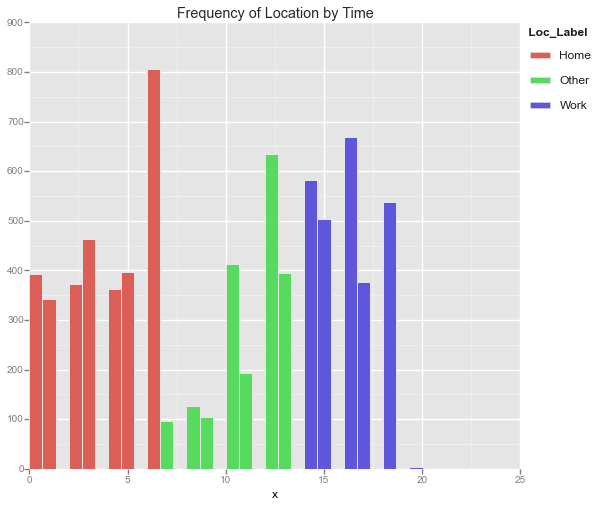

<ggplot: (495297965)>

In [744]:
ggplot(qq, aes('x', weight='value', fill='loc_label')) + \
    geom_bar() + \
    ggtitle("Frequency of Location by Time")

# Resample dates by specific period (hours, days, weeks)

In [349]:
weekday_patterns['freq'] = 0
weekday_patterns = weekday_patterns.set_index('datetime')
weekday_patterns = weekday_patterns.groupby(['weekday', 'loc_label']).resample('D', how=len)
weekday_patterns.head()

freq
weekday loc_label datetime        
Friday  home      2014-11-07   363
        other     2014-11-07   193
        work      2014-11-07   537
Monday  home      2014-11-03   393
        other     2014-11-03    97

# Where you are by dates

In [393]:
day_time_patterns = ld_wk[['datetime', 'loc_label']]

day_time_patterns['hr'] = day_time_patterns.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)
day_time_patterns.hr = pd.Categorical(day_time_patterns.hr)
day_time_patterns.hr = day_time_patterns.hr.astype(float)

# TODO: remove this weekday code if already using day_value
day_time_patterns['weekday'] = day_time_patterns.datetime.map(lambda x: calendar.day_name[x.weekday()])
day_time_patterns.weekday = pd.Categorical(day_time_patterns.weekday, order_of_weekdays)

day_time_patterns.loc_label = pd.Categorical(day_time_patterns.loc_label)
day_time_patterns.head()

,datetime,loc_label,hr,weekday
0,2014-11-09 23:59:18.731,other,23.983333,Sunday
1,2014-11-09 23:58:30.267,other,23.966667,Sunday
2,2014-11-09 23:57:37.062,other,23.950000,Sunday
3,2014-11-09 23:56:46.554,other,23.933333,Sunday
4,2014-11-09 23:55:56.987,other,23.916667,Sunday


# Show location by time of day (seaborn plot)

In [394]:
def get_day_num(day): 
    if day == 'Monday':
        return 1
    elif day == 'Tuesday':
        return 2    
    elif day == 'Wednesday':
        return 3    
    elif day == 'Thursday':
        return 4    
    elif day == 'Friday':
        return 5    
    elif day == 'Saturday':
        return 6    
    elif day == 'Sunday':
        return 7

day_time_patterns['day_value'] = day_time_patterns.weekday.astype(str).map(lambda x: get_day_num(x))

In [608]:
day_time_patterns.rename(columns={'loc_label': 'Location'}, inplace=True)
day_time_patterns.head()

,datetime,Location,hr,weekday,day_value
0,2014-11-09 23:59:18.731,other,23.983333,Sunday,7
1,2014-11-09 23:58:30.267,other,23.966667,Sunday,7
2,2014-11-09 23:57:37.062,other,23.950000,Sunday,7
3,2014-11-09 23:56:46.554,other,23.933333,Sunday,7
4,2014-11-09 23:55:56.987,other,23.916667,Sunday,7


# Day of week by time of day for location

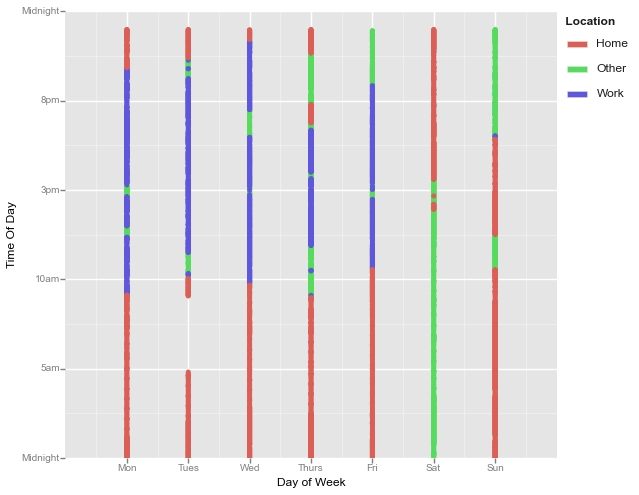

<ggplot: (491265717)>

In [716]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

ggplot(day_time_patterns, aes('day_value', 'hr', color='Location')) + \
    geom_point() + \
    scale_x_continuous(name = "Day of Week", breaks=range(1,8), labels=weekday_label) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label)

In [764]:
meat = meat.dropna(thresh=800, axis=1) # drop columns that have fewer than 800 observations
ts = meat.set_index(['date'])
ts.head(10)

,beef,veal,pork,lamb_and_mutton
date,,,,
1944-01-01,751,85,1280,89
1944-02-01,713,77,1169,72
1944-03-01,741,90,1128,75
1944-04-01,650,89,978,66
1944-05-01,681,106,1029,78
1944-06-01,658,125,962,79
1944-07-01,662,142,796,82
1944-08-01,787,175,748,87
1944-09-01,774,182,678,91


In [765]:
ts.groupby(ts.index.year).sum().head(10)

,beef,veal,pork,lamb_and_mutton
1944,8801,1629,11502,1001
1945,9936,1552,8843,1030
1946,9010,1329,9220,946
1947,10096,1493,8811,779
1948,8766,1323,8486,728
1949,9142,1240,8875,587
1950,9248,1137,9397,581
1951,8549,972,10190,508
1952,9337,1080,10321,635
1953,12055,1451,8971,715
